# Multi Layer Perceptron
### Mehdi Lotfipour

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Fisrt we start by defining mathematical functions.

In [2]:
#make structured dataset from time series data
def dataset_maker(series_data, input_dim, target_dis):
    x = np.ones([ (series_data.shape[0] - (input_dim + target_dis) + 1), (input_dim + 1) ])
    for i in range(input_dim):
        x[:,i] = np.copy(series_data[i : (x.shape[0] + i) , 0])
    x[:,-1] = np.copy(series_data[(input_dim + target_dis - 1) : , 0])
    return x

#sigmoid function
def sigmoid(net, g, a):
    x = net * g * a
    z = (2 * abs(a)) / (1 + np.exp(-x))
    return z

#tanh function
def tanh(net, g, a):
    x = net * g * a
    nominator = 2
    denominator = 1 + np.exp(-2 * x)
    z = (nominator / denominator) - 1
    z *= (1 / a) 
    return z

#identity function
def iden(net):
    return net

#activate w.r.t function type
def activate(activation_func, net, g, a):
    if activation_func == 'sigmoid':
        return sigmoid(net, g, a)
    elif activation_func == 'tanh':
        return tanh(net, g, a)
    elif activation_func == 'iden':
        return iden(net)

#derivative activate w.r.t function type
def activate_der(activation_func, net, g, a, wrt = 'net'):
    #sigmoid derivation
    if activation_func == 'sigmoid':
        z = sigmoid(net, g, a)
        der = z * (1 - z)
        if wrt == 'net':
            return (2 * g * a ** 2) * der
        elif wrt == 'g':
            return (2 * net * a ** 2) * der
        elif wrt == 'a':
            return (2 * net * a * g) * der + (2 * z)
    #tanh derivation
    elif activation_func == 'tanh':
        z = tanh(net, g, a)
        der = (1 - z ** 2)
        if wrt == 'net':
            return g * der
        elif wrt == 'g':
            return net * der * (1/a)
        elif wrt == 'a':
            return der * (net * g / a) + (-z / (a ** 2))
    #identity derivation
    elif activation_func == 'iden':
        return np.ones(net.shape)

Now we define a class to make a network object. When we initialize a network it keeps prameters and other running network values in itself. We define a network by its structure size, activation function types, learning rates, starting parameter values and limits. After that we define two main function of network:

feed forward

back propagation

they only change state of network and return nothing. In feed forward we find outputs w.r.t input matrix. In back propagation we find error and change parameters w.r.t target matrix and last feed forward step input matrix.

In [3]:
class MLP_NN():
    #wa keep structure and layers of a network in an object of MLP_NN class
    
    #instance initializing
    def __init__(self, structure, activate, k_1, k_2,
                 alpha_WB, alpha_ag, beta_WB, beta_ag,
                 eta_W= 0.01, eta_B= 0.01, eta_a= 0, eta_g= 0,
                 w_lower= 0, w_upper= 1, first_g= 1, first_a= 0.5):
        #structure is a list of dimensions: [5,3,3,2] means a network with input of dimension 5, two hidden
        #layers of size 3 and an output of two dimension.
        #activate is list of layers activation function type
        #K are emotional learning constants
        #alphas and betas are momentum constants
        #etas are learning rates, alpha and beta are momentums constants
        #limits are boundry of first values of W & B
        #firsts are initial parameter value
        
        #structure of network
        #keep details for each layer
        self.act = [0] + activate
        self.structure = structure
        self.max_layer = len(structure) - 1
        self.k_1 = k_1
        self.k_2 = k_2
        self.alpha_WB = alpha_WB
        self.alpha_ag = alpha_ag
        self.beta_WB = beta_WB
        self.beta_ag = beta_ag
        #keep matrices of parameters
        self.W = [0] * (self.max_layer + 1)
        self.B = [0] * (self.max_layer + 1)
        self.g = [0] * (self.max_layer + 1)
        self.a = [0] * (self.max_layer + 1)
        self.eta_W = [eta_W] * (self.max_layer + 1)
        self.eta_B = [eta_B] * (self.max_layer + 1)
        self.eta_a = [eta_a] * (self.max_layer + 1)
        self.eta_g = [eta_g] * (self.max_layer + 1)
        #setting starting parameters
        #for each layer
        for i in range(1, self.max_layer + 1):
            #random numbers for first value of weights
            self.W[i] = np.random.uniform(low= w_lower, high= w_upper, size= (structure[i], structure[i-1])) * np.sqrt(2 / structure[i-1])
            #zero numbers for first value of bias
            self.B[i] = np.zeros([structure[i], 1])
            #fix numbers for first value of g & a
            self.g[i] = np.ones([structure[i], 1]) * first_g
            self.a[i] = np.ones([structure[i], 1]) * first_a
        
        #feed forward values
        #keep vectors of outputs & nets
        self.Output = [0] * (self.max_layer + 1)
        self.Net = [0] * (self.max_layer + 1)
        
        #back propagation values
        #keep errors & r & deltas & sigmas
        #We keep error for time (k) and (k-1)
        self.Error = [[0] * (self.max_layer + 1), [0] * (self.max_layer + 1), [0] * (self.max_layer + 1)]
        self.r = 0
        self.delta = [0] * (self.max_layer + 1)
        self.sigma_a = [0] * (self.max_layer + 1)
        self.sigma_g = [0] * (self.max_layer + 1)
        #keep change of aprameters
        self.W_U = [[0] * (self.max_layer + 1), [0] * (self.max_layer + 1), [0] * (self.max_layer + 1)]
        self.B_U = [[0] * (self.max_layer + 1), [0] * (self.max_layer + 1), [0] * (self.max_layer + 1)]
        self.g_U = [[0] * (self.max_layer + 1), [0] * (self.max_layer + 1), [0] * (self.max_layer + 1)]
        self.a_U = [[0] * (self.max_layer + 1), [0] * (self.max_layer + 1), [0] * (self.max_layer + 1)]
        
    #perform a feed forward step through all layers and update outputs and nets
    def feed_fwd(self, input_matrix):
        #putting input_matrix in Output[0]
        self.Output[0] = input_matrix.copy()
        #finding outputs and nets
        #for each layer
        for i in range(1, self.max_layer + 1):
            #net(i) = (W(i) dot output(i-1)) + B(i)
            #output(i) = f(net(i), g(i), a(i))
            self.Net[i] = np.dot(self.W[i], self.Output[i - 1]) + self.B[i]
            self.Output[i] = activate(self.act[i], self.Net[i], self.g[i], self.a[i])
   
    
    #perform a back propagation in network and sets errors, r, deltas and sigmas w.r.t target
    def back_prog(self, target_matrix):
        #finding last layer error & delta & sigma
        #error(L) = (d - output(L))
        #r = (k1 + k2) * error(L) - k2 * error(L-2)
        #delta(L) = (k1 + k2) * r * f'(net(L), g(L), a(L))
        #sigma(L) = (k1 + k2) * r * f*(net(L), g(L), a(L))
        #adding new time for error
        self.Error.append([0] * (self.max_layer + 1))
        self.Error[-1][-1] = (target_matrix - self.Output[-1])
        self.r = (self.k_1 + self.k_2) * self.Error[-1][-1] - (self.k_2 * self.Error[-3][-1])
        self.delta[-1] = (self.k_1 + self.k_2) * self.r * activate_der(self.act[-1], self.Net[-1], self.g[-1], self.a[-1], 'net')
        self.sigma_g[-1] = (self.k_1 + self.k_2) * self.r * activate_der(self.act[-1], self.Net[-1], self.g[-1], self.a[-1], 'g')
        self.sigma_a[-1] = (self.k_1 + self.k_2) * self.r * activate_der(self.act[-1], self.Net[-1], self.g[-1], self.a[-1], 'a')
        #for each layer backward
        for i in range(self.max_layer-1, 0, -1):
            #error(j) = (delta(j+1) dot W(j+1))
            #delta(j) = error(j) * f'(net(j), g(j), a(j))
            #sigma(j) = error(j) * f*(net(j), g(j), a(j))
            self.Error[-1][i] = np.einsum('ij, ik -> kj', self.delta[i + 1], self.W[i + 1])
            self.delta[i] = self.Error[-1][i] * activate_der(self.act[i], self.Net[i], self.g[i], self.a[i], 'net')
            self.sigma_g[i] = self.Error[-1][i] * activate_der(self.act[i], self.Net[i], self.g[i], self.a[i], 'g')
            self.sigma_a[i] = self.Error[-1][i] * activate_der(self.act[i], self.Net[i], self.g[i], self.a[i], 'a')
        #removing oldest time for error
        self.Error.pop(0)
        
        #finding parameter changes
        #n = number of records
        n = target_matrix.shape[1]
        #for each layer
        for i in range(1, self.max_layer + 1):
            #delta_W(j) = eta of W(j) * (delta(j) dot output(j-1)) / n
            #delta_B(j) = eta of B(j) * delta(j) / n
            #delta_g(j) = eta of j(j) * sigma of g(j) / n
            #delta_a(j) = eta of a(j) * sigma of a(j) / n
            self.W_U[-1][i] = np.einsum('ij, kj -> ik', self.delta[i], self.Output[i - 1]) * (1 / n)
            self.B_U[-1][i] = np.einsum('ij -> i', self.delta[i]) * (1 / n)
            self.g_U[-1][i] = np.einsum('ij -> i', self.sigma_g[i]) * (1 / n)
            self.a_U[-1][i] = np.einsum('ij -> i', self.sigma_a[i]) * (1 / n)
            #delta_W(j) = delta_W(j) + alpha * delta_W(j-1) + beta * delta_W(j-2)
            #delta_B(j) = delta_B(j) + alpha * delta_B(j-1) + beta * delta_B(j-2)
            #delta_a(j) = delta_a(j) + alpha * delta_a(j-1) + beta * delta_a(j-2)
            #delta_g(j) = delta_g(j) + alpha * delta_g(j-1) + beta * delta_g(j-2)
            self.W_U[-1][i] += self.alpha_WB * self.W_U[-2][i] + self.beta_WB * self.W_U[-3][i]
            self.B_U[-1][i] += self.alpha_WB * self.B_U[-2][i] + self.beta_WB * self.B_U[-3][i]
            self.a_U[-1][i] += self.alpha_ag * self.a_U[-2][i] + self.beta_ag * self.a_U[-3][i]
            self.g_U[-1][i] += self.alpha_ag * self.g_U[-2][i] + self.beta_ag * self.g_U[-3][i]
    
        #applying changes to parameters
        #for each layer
        for i in range(1, self.max_layer + 1):
            #W(j)(K) = W(j)(K-1) + eta of W(j) * delta of W(j)(K)
            #B(j)(K) = B(j)(K-1) + eta of B(j) * delta of B(j)(K)
            #g(j)(K) = g(j)(K-1) + eta of g(j) * delta of g(j)(K)
            #a(j)(K) = a(j)(K-1) + eta of a(j) * delta of a(j)(K)
            self.W[i] += self.eta_W[i] * self.W_U[-1][i]
            self.B[i] += self.eta_B[i] * self.B_U[-1][i].reshape(-1, 1)
            self.g[i] += self.eta_g[i] * self.g_U[-1][i].reshape(-1, 1)
            self.a[i] += self.eta_a[i] * self.a_U[-1][i].reshape(-1, 1)
        
        #adding new time for parameter changes
        self.W_U.append([0] * (self.max_layer + 1))
        self.B_U.append([0] * (self.max_layer + 1))
        self.g_U.append([0] * (self.max_layer + 1))
        self.a_U.append([0] * (self.max_layer + 1))
        #removing oldest time for parameter changes
        self.W_U.pop(0)
        self.B_U.pop(0)
        self.g_U.pop(0)
        self.a_U.pop(0)

Here we import the given dataset which is a one dimensional time serie. Then use 50% of data for training the network and 50% of data for testing the trained network. Then we normalize all data based on trainig data with z-score method. After that we make a structured dataset. Each record is a 10 dimensional step of time serie and its target is 7'th lag of the time serie. 

In [4]:
#import given data
given_data = pd.read_excel('Data.xlsx', header= None)
given_data = np.array(given_data)
#keeping 50% of data for final test
split_ratio = 0.5
n = int(given_data.shape[0] * split_ratio)
train_data = given_data[:n]
test_data = given_data[n:]

#z-score normalizing
mean_x = np.mean(train_data)
std_x = np.std(train_data)
train_data_zs = (train_data - mean_x) / std_x
test_data_zs = (test_data - mean_x) / std_x

Here we start to define different networks and show their result.

### Part .a

#### Emotional Learning

For this part we use tanh activation function and z-score normalized dataset and set first_g = 1 and first_a = 0.5 and range of w (-1~1). First layer (input layer) has 10 dimensions, second layer (hidden layer) has 20 dimensions and last layer (output layer) has only one dimension. k1 = 0.7 & k2 = 0.3 and all alphas and betas are zero.

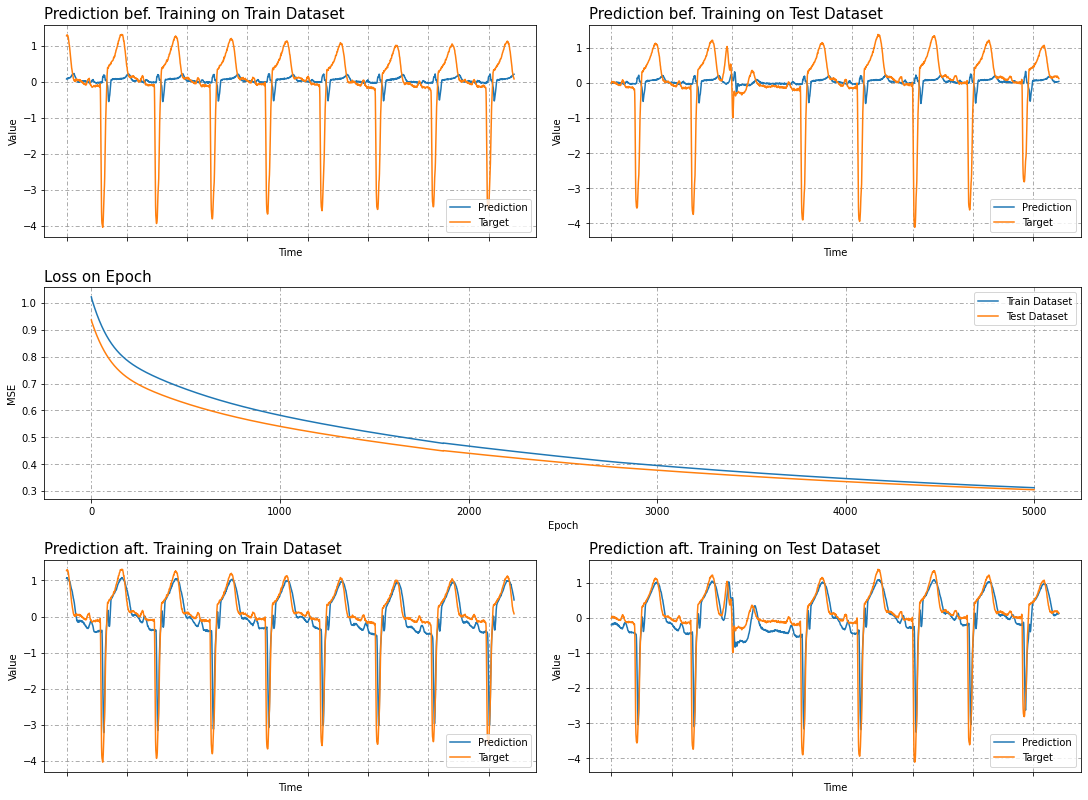

In [5]:
#making structured dataset
#record's dimension
input_dimension = 10
#distance of target
target_distance = 7
#making two dataset: one for training phase and one for testing phase
#each dataset is consisted of "input" and "target output"
dataset_train = dataset_maker(train_data_zs, input_dimension, target_distance)
dataset_test = dataset_maker(test_data_zs, input_dimension, target_distance)
X_train = dataset_train.T[:input_dimension]
Y_train = dataset_train.T[input_dimension:]
X_test = dataset_test.T[:input_dimension]
Y_test = dataset_test.T[input_dimension:]

#we defined the network w.r.t condition we are interested in
saeid = MLP_NN([10, 20, 1], ['tanh', 'iden'], k_1= 0.7, k_2= 0.3,
               alpha_WB= 0, alpha_ag= 0, beta_WB= 0, beta_ag= 0,
               eta_W= 0.001, eta_B= 0.001, eta_a= 0.001, eta_g= 0.001,
               w_lower= -1, w_upper= 1, first_g= 1, first_a= 0.5)

#we set iteration number
epoch_size = 5000
#we difine two list to keep result of train
#and test dataset for each epoch in themm
loss_train = []
loss_test = []

#check network prediction on train and test dataset before training
saeid.feed_fwd(X_train)
first_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
first_test_predict = saeid.Output[-1].copy().reshape(-1)

#for each epoch
for epoch in range(epoch_size):
    #loss of test dataset
    #feed forward
    saeid.feed_fwd(X_test)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_test) ** 2) / Y_test.shape[1]
    #keeping test loss of epoch
    loss_test.append(loss)

    #loss of train dataset
    #feed forward
    saeid.feed_fwd(X_train)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_train) ** 2) / Y_train.shape[1]
    #keeping train loss of epoch
    loss_train.append(loss)
    
    #training on training dataset
    saeid.back_prog(Y_train)
    
#check network prediction on train and test dataset after training
saeid.feed_fwd(X_train)
trained_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
trained_test_predict = saeid.Output[-1].copy().reshape(-1)

#showing result
fig = plt.figure(constrained_layout=True, figsize=(15,11))
gs = GridSpec(3, 2, figure= fig)
ax = [0] * 5
#prediction of non-trained network
ax[0] = fig.add_subplot(gs[0,0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_xticklabels('')
ax[0].set_title('Prediction bef. Training on Train Dataset', loc= 'left', size= 15)
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(first_train_predict, label= 'Prediction')
ax[0].plot(Y_train.reshape(-1), label= 'Target')
ax[0].legend(loc=4)
ax[1] = fig.add_subplot(gs[0,1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].set_xticklabels('')
ax[1].set_title('Prediction bef. Training on Test Dataset', loc= 'left', size= 15)
ax[1].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[1].plot(first_test_predict, label= 'Prediction')
ax[1].plot(Y_test.reshape(-1), label= 'Target')
ax[1].legend(loc=4)
#loss values
ax[2] = fig.add_subplot(gs[1,:])
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('MSE')
ax[2].set_title('Loss on Epoch', loc= 'left', size= 15)
ax[2].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[2].plot(loss_train, label= 'Train Dataset')
ax[2].plot(loss_test, label= 'Test Dataset')
ax[2].legend()
#prediction of trained network
ax[3] = fig.add_subplot(gs[2,0])
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Value')
ax[3].set_xticklabels('')
ax[3].set_title('Prediction aft. Training on Train Dataset', loc= 'left', size= 15)
ax[3].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[3].plot(trained_train_predict, label= 'Prediction')
ax[3].plot(Y_train.reshape(-1), label= 'Target')
ax[3].legend(loc=4)
ax[4] = fig.add_subplot(gs[2,1])
ax[4].set_xlabel('Time')
ax[4].set_ylabel('Value')
ax[4].set_xticklabels('')
ax[4].set_title('Prediction aft. Training on Test Dataset', loc= 'left', size= 15)
ax[4].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[4].plot(trained_test_predict, label= 'Prediction')
ax[4].plot(Y_test.reshape(-1), label= 'Target')
ax[4].legend(loc=4)

### Part .b

#### Momentums only for Weights and Biases

For this part we use tanh activation function and z-score normalized dataset and set first_g = 1 and first_a = 0.5 and range of w (-1~1). First layer (input layer) has 10 dimensions, second layer (hidden layer) has 20 dimensions and last layer (output layer) has only one dimension. k1 = 1 & k2 = 0 & alpha of WB = 0.5 & beta of WB = 0.1 and set alpha and beta of a&g to zero.

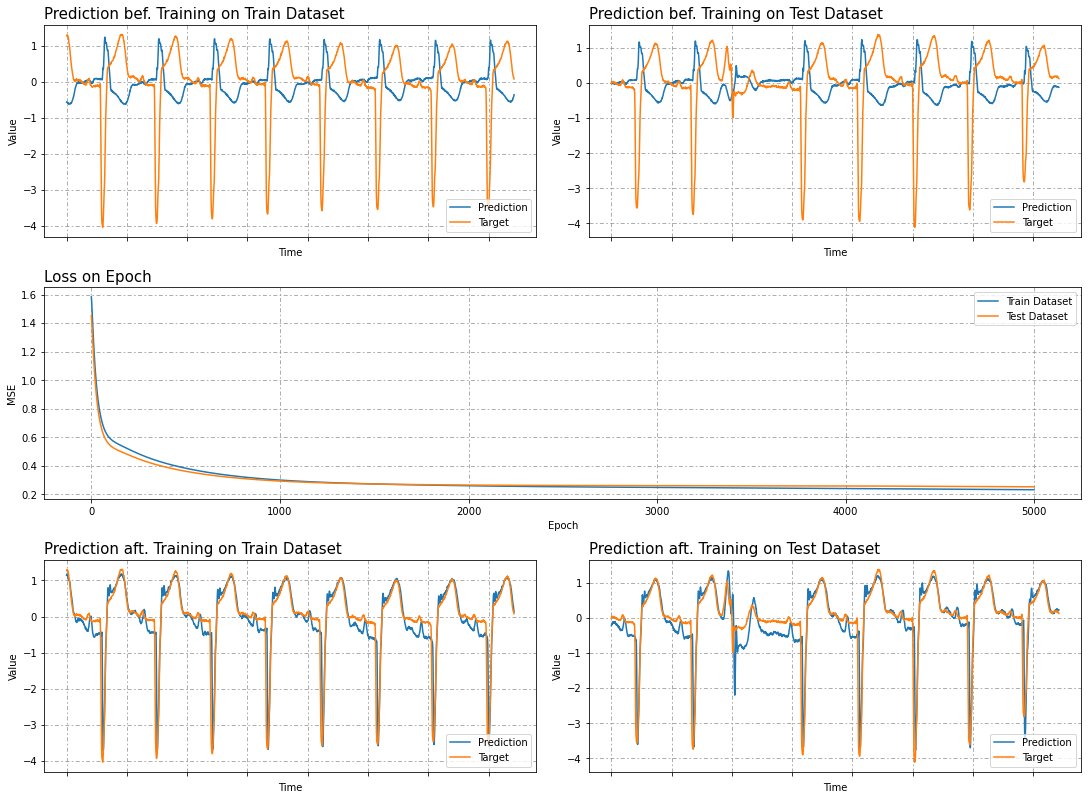

In [6]:
#making structured dataset
#record's dimension
input_dimension = 10
#distance of target
target_distance = 7
#making two dataset: one for training phase and one for testing phase
#each dataset is consisted of "input" and "target output"
dataset_train = dataset_maker(train_data_zs, input_dimension, target_distance)
dataset_test = dataset_maker(test_data_zs, input_dimension, target_distance)
X_train = dataset_train.T[:input_dimension]
Y_train = dataset_train.T[input_dimension:]
X_test = dataset_test.T[:input_dimension]
Y_test = dataset_test.T[input_dimension:]

#we defined the network w.r.t condition we are interested in
saeid = MLP_NN([10, 20, 1], ['tanh', 'iden'], k_1= 1, k_2= 0,
               alpha_WB= 0.5, alpha_ag= 0, beta_WB= 0.1, beta_ag= 0,
               eta_W= 0.001, eta_B= 0.001, eta_a= 0.001, eta_g= 0.001,
               w_lower= -1, w_upper= 1, first_g= 1, first_a= 0.5)

#we set iteration number
epoch_size = 5000
#we difine two list to keep result of train
#and test dataset for each epoch in themm
loss_train = []
loss_test = []

#check network prediction on train and test dataset before training
saeid.feed_fwd(X_train)
first_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
first_test_predict = saeid.Output[-1].copy().reshape(-1)

#for each epoch
for epoch in range(epoch_size):
    #loss of test dataset
    #feed forward
    saeid.feed_fwd(X_test)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_test) ** 2) / Y_test.shape[1]
    #keeping test loss of epoch
    loss_test.append(loss)

    #loss of train dataset
    #feed forward
    saeid.feed_fwd(X_train)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_train) ** 2) / Y_train.shape[1]
    #keeping train loss of epoch
    loss_train.append(loss)
    
    #training on training dataset
    saeid.back_prog(Y_train)
    
#check network prediction on train and test dataset after training
saeid.feed_fwd(X_train)
trained_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
trained_test_predict = saeid.Output[-1].copy().reshape(-1)

#showing result
fig = plt.figure(constrained_layout=True, figsize=(15,11))
gs = GridSpec(3, 2, figure= fig)
ax = [0] * 5
#prediction of non-trained network
ax[0] = fig.add_subplot(gs[0,0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_xticklabels('')
ax[0].set_title('Prediction bef. Training on Train Dataset', loc= 'left', size= 15)
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(first_train_predict, label= 'Prediction')
ax[0].plot(Y_train.reshape(-1), label= 'Target')
ax[0].legend(loc=4)
ax[1] = fig.add_subplot(gs[0,1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].set_xticklabels('')
ax[1].set_title('Prediction bef. Training on Test Dataset', loc= 'left', size= 15)
ax[1].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[1].plot(first_test_predict, label= 'Prediction')
ax[1].plot(Y_test.reshape(-1), label= 'Target')
ax[1].legend(loc=4)
#loss values
ax[2] = fig.add_subplot(gs[1,:])
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('MSE')
ax[2].set_title('Loss on Epoch', loc= 'left', size= 15)
ax[2].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[2].plot(loss_train, label= 'Train Dataset')
ax[2].plot(loss_test, label= 'Test Dataset')
ax[2].legend()
#prediction of trained network
ax[3] = fig.add_subplot(gs[2,0])
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Value')
ax[3].set_xticklabels('')
ax[3].set_title('Prediction aft. Training on Train Dataset', loc= 'left', size= 15)
ax[3].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[3].plot(trained_train_predict, label= 'Prediction')
ax[3].plot(Y_train.reshape(-1), label= 'Target')
ax[3].legend(loc=4)
ax[4] = fig.add_subplot(gs[2,1])
ax[4].set_xlabel('Time')
ax[4].set_ylabel('Value')
ax[4].set_xticklabels('')
ax[4].set_title('Prediction aft. Training on Test Dataset', loc= 'left', size= 15)
ax[4].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[4].plot(trained_test_predict, label= 'Prediction')
ax[4].plot(Y_test.reshape(-1), label= 'Target')
ax[4].legend(loc=4)

### Part .c

#### Momentums for Weights & Biases & g & a

For this part we use tanh activation function and z-score normalized dataset and set first_g = 1 and first_a = 0.5 and range of w (-1~1). First layer (input layer) has 10 dimensions, second layer (hidden layer) has 20 dimensions and last layer (output layer) has only one dimension. k1 = 1 & k2 = 0 & alpha of WB = alpha of ag = 0.5 & beta of WB = beta of ag = 0.1

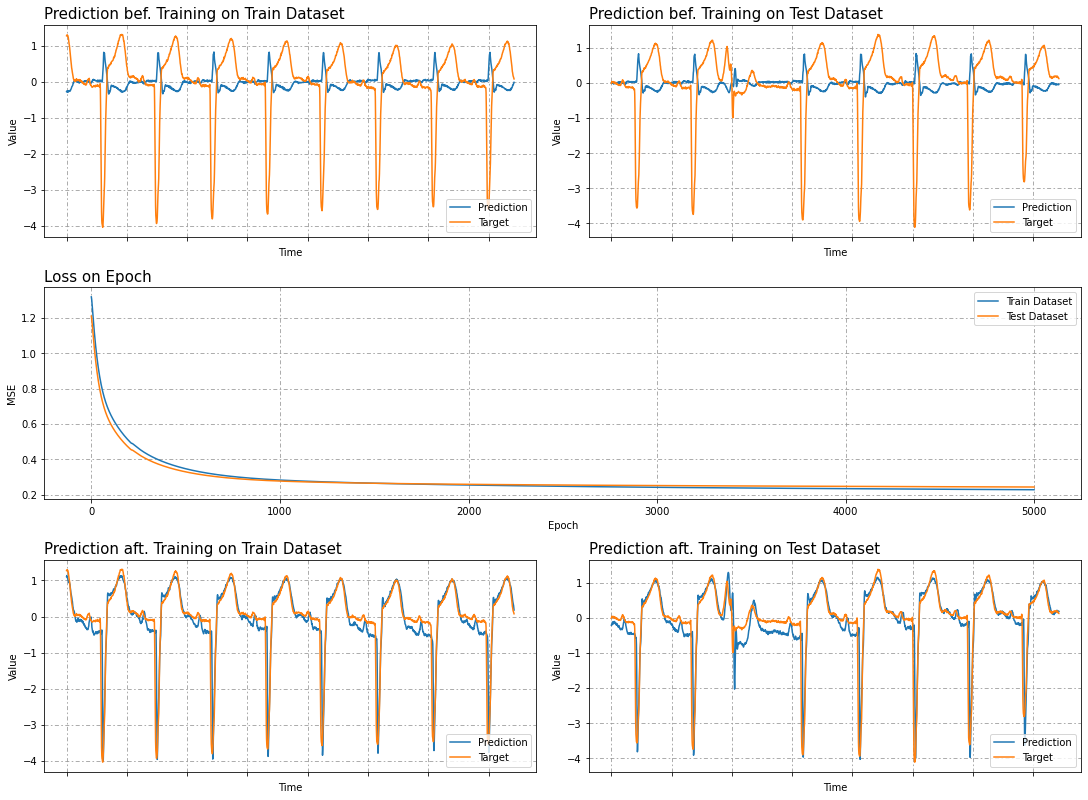

In [7]:
#making structured dataset
#record's dimension
input_dimension = 10
#distance of target
target_distance = 7
#making two dataset: one for training phase and one for testing phase
#each dataset is consisted of "input" and "target output"
dataset_train = dataset_maker(train_data_zs, input_dimension, target_distance)
dataset_test = dataset_maker(test_data_zs, input_dimension, target_distance)
X_train = dataset_train.T[:input_dimension]
Y_train = dataset_train.T[input_dimension:]
X_test = dataset_test.T[:input_dimension]
Y_test = dataset_test.T[input_dimension:]

#we defined the network w.r.t condition we are interested in
saeid = MLP_NN([10, 20, 1], ['tanh', 'iden'], k_1= 1, k_2= 0,
               alpha_WB= 0.5, alpha_ag= 0.5, beta_WB= 0.1, beta_ag= 0.1,
               eta_W= 0.001, eta_B= 0.001, eta_a= 0.001, eta_g= 0.001,
               w_lower= -1, w_upper= 1, first_g= 1, first_a= 0.5)

#we set iteration number
epoch_size = 5000
#we difine two list to keep result of train
#and test dataset for each epoch in themm
loss_train = []
loss_test = []

#check network prediction on train and test dataset before training
saeid.feed_fwd(X_train)
first_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
first_test_predict = saeid.Output[-1].copy().reshape(-1)

#for each epoch
for epoch in range(epoch_size):
    #loss of test dataset
    #feed forward
    saeid.feed_fwd(X_test)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_test) ** 2) / Y_test.shape[1]
    #keeping test loss of epoch
    loss_test.append(loss)

    #loss of train dataset
    #feed forward
    saeid.feed_fwd(X_train)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_train) ** 2) / Y_train.shape[1]
    #keeping train loss of epoch
    loss_train.append(loss)
    
    #training on training dataset
    saeid.back_prog(Y_train)
    
#check network prediction on train and test dataset after training
saeid.feed_fwd(X_train)
trained_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
trained_test_predict = saeid.Output[-1].copy().reshape(-1)

#showing result
fig = plt.figure(constrained_layout=True, figsize=(15,11))
gs = GridSpec(3, 2, figure= fig)
ax = [0] * 5
#prediction of non-trained network
ax[0] = fig.add_subplot(gs[0,0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_xticklabels('')
ax[0].set_title('Prediction bef. Training on Train Dataset', loc= 'left', size= 15)
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(first_train_predict, label= 'Prediction')
ax[0].plot(Y_train.reshape(-1), label= 'Target')
ax[0].legend(loc=4)
ax[1] = fig.add_subplot(gs[0,1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].set_xticklabels('')
ax[1].set_title('Prediction bef. Training on Test Dataset', loc= 'left', size= 15)
ax[1].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[1].plot(first_test_predict, label= 'Prediction')
ax[1].plot(Y_test.reshape(-1), label= 'Target')
ax[1].legend(loc=4)
#loss values
ax[2] = fig.add_subplot(gs[1,:])
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('MSE')
ax[2].set_title('Loss on Epoch', loc= 'left', size= 15)
ax[2].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[2].plot(loss_train, label= 'Train Dataset')
ax[2].plot(loss_test, label= 'Test Dataset')
ax[2].legend()
#prediction of trained network
ax[3] = fig.add_subplot(gs[2,0])
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Value')
ax[3].set_xticklabels('')
ax[3].set_title('Prediction aft. Training on Train Dataset', loc= 'left', size= 15)
ax[3].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[3].plot(trained_train_predict, label= 'Prediction')
ax[3].plot(Y_train.reshape(-1), label= 'Target')
ax[3].legend(loc=4)
ax[4] = fig.add_subplot(gs[2,1])
ax[4].set_xlabel('Time')
ax[4].set_ylabel('Value')
ax[4].set_xticklabels('')
ax[4].set_title('Prediction aft. Training on Test Dataset', loc= 'left', size= 15)
ax[4].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[4].plot(trained_test_predict, label= 'Prediction')
ax[4].plot(Y_test.reshape(-1), label= 'Target')
ax[4].legend(loc=4)

### Part .d

#### Momentums for Weights & Biases & g & a with different constants

For this part we use tanh activation function and z-score normalized dataset and set first_g = 1 and first_a = 0.5 and range of w (-1~1). First layer (input layer) has 10 dimensions, second layer (hidden layer) has 20 dimensions and last layer (output layer) has only one dimension. k1 = 1 & k2 = 0 & alpha of WB = 0.5 & beta of WB = 0.1 & alpha of ag = 0.3 & beta of ag = 0.05

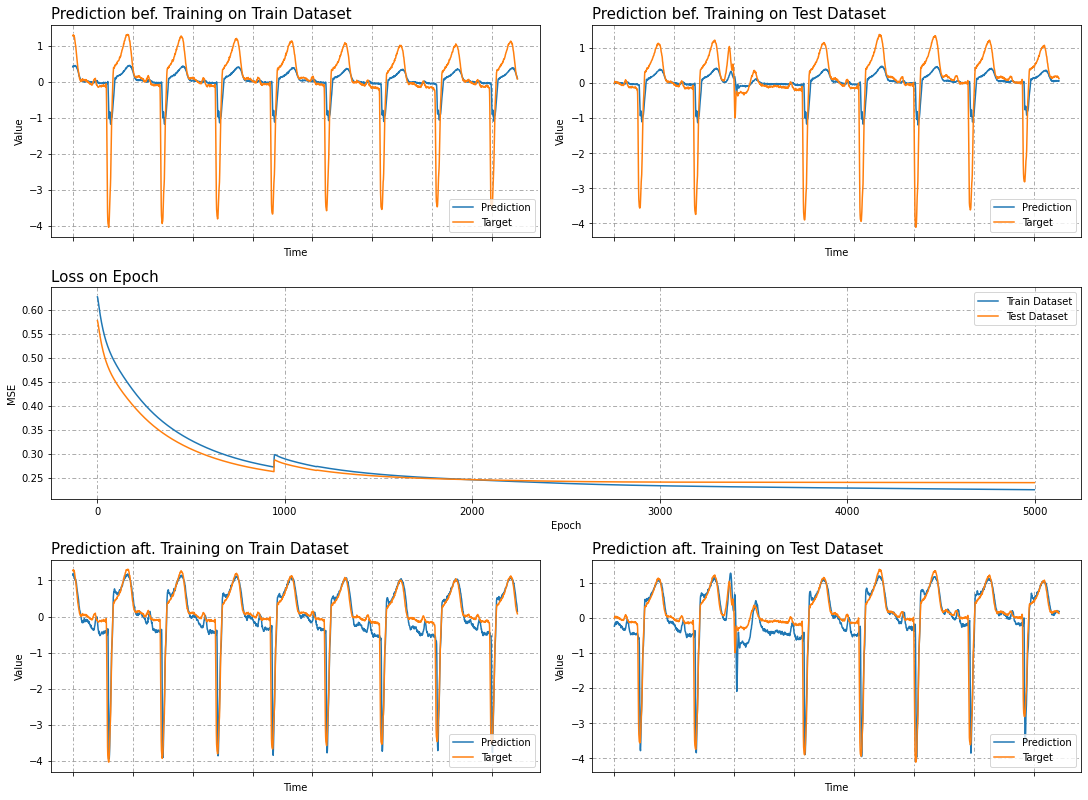

In [8]:
#making structured dataset
#record's dimension
input_dimension = 10
#distance of target
target_distance = 7
#making two dataset: one for training phase and one for testing phase
#each dataset is consisted of "input" and "target output"
dataset_train = dataset_maker(train_data_zs, input_dimension, target_distance)
dataset_test = dataset_maker(test_data_zs, input_dimension, target_distance)
X_train = dataset_train.T[:input_dimension]
Y_train = dataset_train.T[input_dimension:]
X_test = dataset_test.T[:input_dimension]
Y_test = dataset_test.T[input_dimension:]

#we defined the network w.r.t condition we are interested in
saeid = MLP_NN([10, 20, 1], ['tanh', 'iden'], k_1= 1, k_2= 0,
               alpha_WB= 0.5, alpha_ag= 0.3, beta_WB= 0.1, beta_ag= 0.05,
               eta_W= 0.001, eta_B= 0.001, eta_a= 0.001, eta_g= 0.001,
               w_lower= -1, w_upper= 1, first_g= 1, first_a= 0.5)

#we set iteration number
epoch_size = 5000
#we difine two list to keep result of train
#and test dataset for each epoch in themm
loss_train = []
loss_test = []

#check network prediction on train and test dataset before training
saeid.feed_fwd(X_train)
first_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
first_test_predict = saeid.Output[-1].copy().reshape(-1)

#for each epoch
for epoch in range(epoch_size):
    #loss of test dataset
    #feed forward
    saeid.feed_fwd(X_test)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_test) ** 2) / Y_test.shape[1]
    #keeping test loss of epoch
    loss_test.append(loss)

    #loss of train dataset
    #feed forward
    saeid.feed_fwd(X_train)
    #Loss = (sum of all N record loss) / N
    loss = np.sum((saeid.Output[-1] - Y_train) ** 2) / Y_train.shape[1]
    #keeping train loss of epoch
    loss_train.append(loss)
    
    #training on training dataset
    saeid.back_prog(Y_train)
    
#check network prediction on train and test dataset after training
saeid.feed_fwd(X_train)
trained_train_predict = saeid.Output[-1].copy().reshape(-1)
saeid.feed_fwd(X_test)
trained_test_predict = saeid.Output[-1].copy().reshape(-1)

#showing result
fig = plt.figure(constrained_layout=True, figsize=(15,11))
gs = GridSpec(3, 2, figure= fig)
ax = [0] * 5
#prediction of non-trained network
ax[0] = fig.add_subplot(gs[0,0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_xticklabels('')
ax[0].set_title('Prediction bef. Training on Train Dataset', loc= 'left', size= 15)
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(first_train_predict, label= 'Prediction')
ax[0].plot(Y_train.reshape(-1), label= 'Target')
ax[0].legend(loc=4)
ax[1] = fig.add_subplot(gs[0,1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].set_xticklabels('')
ax[1].set_title('Prediction bef. Training on Test Dataset', loc= 'left', size= 15)
ax[1].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[1].plot(first_test_predict, label= 'Prediction')
ax[1].plot(Y_test.reshape(-1), label= 'Target')
ax[1].legend(loc=4)
#loss values
ax[2] = fig.add_subplot(gs[1,:])
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('MSE')
ax[2].set_title('Loss on Epoch', loc= 'left', size= 15)
ax[2].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[2].plot(loss_train, label= 'Train Dataset')
ax[2].plot(loss_test, label= 'Test Dataset')
ax[2].legend()
#prediction of trained network
ax[3] = fig.add_subplot(gs[2,0])
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Value')
ax[3].set_xticklabels('')
ax[3].set_title('Prediction aft. Training on Train Dataset', loc= 'left', size= 15)
ax[3].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[3].plot(trained_train_predict, label= 'Prediction')
ax[3].plot(Y_train.reshape(-1), label= 'Target')
ax[3].legend(loc=4)
ax[4] = fig.add_subplot(gs[2,1])
ax[4].set_xlabel('Time')
ax[4].set_ylabel('Value')
ax[4].set_xticklabels('')
ax[4].set_title('Prediction aft. Training on Test Dataset', loc= 'left', size= 15)
ax[4].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[4].plot(trained_test_predict, label= 'Prediction')
ax[4].plot(Y_test.reshape(-1), label= 'Target')
ax[4].legend(loc=4)